In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os
from astroNN.nn.layers import MCDropout
import math


Reading JLA covariance matrix and examinate the min, max and mean from it. 

In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA2.h5')
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)

# scaler_sys = StandardScaler()
# scaler_sys.fit(syscov)
# syscov_sc = scaler_sys.transform(syscov)
data = np.loadtxt(file, skiprows=3)
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov))


-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31)


In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(data[:,1].reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalerdist.transform(errors.reshape(nsize,1))

Text(0.5, 1.0, 'Original matrix extended')

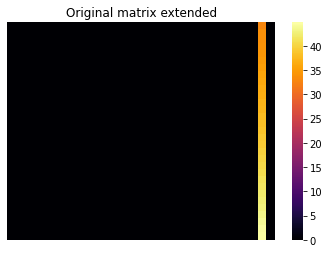

In [4]:
ext_matrix = np.zeros((nsize, nsize+2))

ext_matrix[:, :nsize] = syscov
ext_matrix[:,-2] = data[:,1].reshape(nsize,)
ext_matrix[:, -1] = errors.reshape(nsize,)

sns.heatmap(pd.DataFrame(ext_matrix), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix extended')

Text(0.5, 1.0, 'Original matrix scaled and extended')

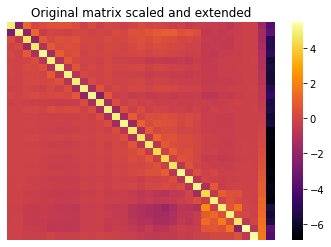

In [5]:
ext_matrix_sc = np.random.rand(nsize, nsize+2)

ext_matrix_sc[:, :nsize] = syscov_sc
ext_matrix_sc[:,-2] = dist_sc.reshape(nsize,)
ext_matrix_sc[:, -1] = errors_logs.reshape(nsize,)

sns.heatmap(pd.DataFrame(ext_matrix_sc), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix scaled and extended')

In [6]:
def permutMatrix(omatrix, nmatrix, measurements, errors):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize+2))
    magnitudes = np.zeros((nmatrix, nsize, nsize+2))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        p = symmetrical(p)
        matrixset[it, :, :nsize] = p
        matrixset[it, :, -2] = measurements[perm]
        matrixset[it, :, -1] = errors[perm]
        magnitudes[it, :, :] = matrixMag(matrixset[it,:,:])
        
    return matrixset, magnitudes


In [7]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
    #         if np.iscomplex(syscov[i,j]):
    #             print("COMPLEX")
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) < np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix

In [8]:
def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    mshape = np.shape(matrix)
    magMatrix = np.zeros(mshape)
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

In [9]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31+2))
covset_noise = np.zeros((numMatrix, 31, 31+2))
# permMatrix = permutMatrix(syscov_sc, numMatrix)
permMatrix, magnitudes = permutMatrix(syscov_sc, numMatrix, dist_sc.reshape(nsize,), errors_logs)
# magnitudes = matrixMag(ext_matrix)
print(np.shape(permMatrix))

(10000, 31, 33)


Text(0.5, 1.0, 'PERMUTATED MATRIX (SCALED)')

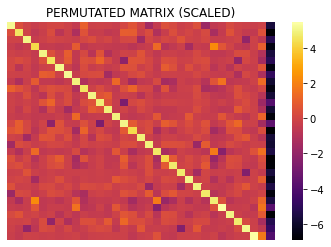

In [10]:
# sns.heatmap(pd.DataFrame(permMatrix[99, :, : ]), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
ext_matrix_2 = np.copy(ext_matrix)
ext_matrix[:,]
sns.heatmap(pd.DataFrame(permMatrix[0, :, :]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX (SCALED)")


Text(0.5, 1.0, 'PERMUTATED MATRIX')

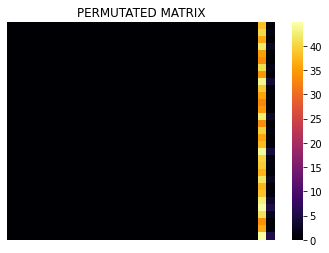

In [11]:
ext_matrix = np.random.rand(nsize, nsize+2)

ext_matrix[:, :nsize] = scalercov.inverse_transform(permMatrix[0, :, :nsize])
ext_matrix[:,-2] = scalerdist.inverse_transform(permMatrix[0, :, -2])
ext_matrix[:, -1] = np.exp(permMatrix[0, :, -2])

sns.heatmap(pd.DataFrame(ext_matrix[:, :]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX")

In [12]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    
    for row in range(nsize):
        for col in range(nsize+2):
            err = np.random.randn()
            if row == col:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-4*err*10**magnitudes[i, row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-3*err*10**orderMag(permMatrix[i, row, col])



 Generating 415 matrix 

 Generating 1346 matrix 

 Generating 1899 matrix

 Generating 2515 matrix 

 Generating 3022 matrix 

 Generating 3897 matrix 

 Generating 4397 matrix

 Generating 4896 matrix 

 Generating 5396 matrix

 Generating 6395 matrix 

 Generating 6895 matrix

 Generating 7268 matrix

 Generating 10000 matrix 

In [13]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)
np.shape(covset_noise_test)

(10000, 31, 33)


(2000, 31, 33)

Text(0.5, 1.0, 'TEST MATRIX')

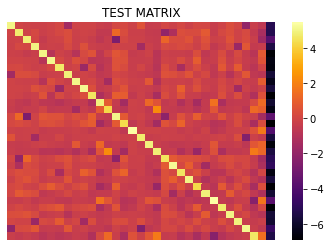

In [14]:
sns.heatmap(pd.DataFrame(covset_test[0,:,:]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")

In [15]:
latent_mean = np.mean(dist_sc)
latent_std = np.std(dist_sc)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=latent_mean, stddev=latent_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [16]:
input_shape = (31, 33, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
use_mse = True
load_weights = False



inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
# ((top_pad, bottom_pad), (left_pad, right_pad))
x = layers.ZeroPadding2D(((5,4),(5,2)))(inputs)
x = layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
shape_enc = K.int_shape(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

# z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 31, 33, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 40, 40, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 16)   160         zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 16)   2320        conv2d[0][0]                     
____________________________________________________________________________________________

In [23]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(shape_enc[1] * shape_enc[2] * shape_enc[3], activation='relu')(latent_inputs)
x = layers.Reshape((shape_enc[1], shape_enc[2], shape_enc[3]))(x)

x = layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(1, kernel_size=kernel_size, activation='linear', strides=2, padding='same')(x)
# x = layers.Conv2DTranspose(1, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
outputs = layers.Cropping2D(cropping=((5, 4), (5, 2)))(x)

# Decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              4800      
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 20, 20, 16)        2320      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 40, 40, 1)         145       
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 31, 33, 1)         0         
Total params: 7,265
Trainable params: 7,265
Non-trainable params: 0
_________________________________________________________

In [24]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_conv')
vae.summary()

Model: "vae_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 31, 33, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 8884      
_________________________________________________________________
decoder (Functional)         (None, 31, 33, 1)         7265      
Total params: 16,149
Trainable params: 16,149
Non-trainable params: 0
_________________________________________________________________


In [25]:
# VAE class from https://github.com/keras-team/keras-io
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [26]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
# vae.fit(mnist_digits, epochs=30, batch_size=128)
covmatrixset = np.concatenate([covset_train, covset_train], axis=0)
covmatrixset = np.expand_dims(covmatrixset, -1).astype("float32")

### TRAINING

In [27]:
vae_train = vae.fit(covmatrixset, epochs=30, batch_size=128)                          

Epoch 1/30
125/125 [==============================] - 2s 17ms/step - loss: -3813.7231 - reconstruction_loss: -4081.7847 - kl_loss: 22.8281
Epoch 2/30
125/125 [==============================] - 2s 17ms/step - loss: -4598.3992 - reconstruction_loss: -5270.9727 - kl_loss: 122.6629
Epoch 3/30
125/125 [==============================] - 2s 17ms/step - loss: -6825.8299 - reconstruction_loss: -7025.0044 - kl_loss: 111.2269
Epoch 4/30
125/125 [==============================] - 2s 17ms/step - loss: -7039.1384 - reconstruction_loss: -7096.7290 - kl_loss: 52.2858
Epoch 5/30
125/125 [==============================] - 2s 17ms/step - loss: -7086.4439 - reconstruction_loss: -7159.8828 - kl_loss: 48.6020
Epoch 6/30
125/125 [==============================] - 2s 16ms/step - loss: -7140.9211 - reconstruction_loss: -7178.4800 - kl_loss: 33.9549
Epoch 7/30
125/125 [==============================] - 2s 17ms/step - loss: -7208.2222 - reconstruction_loss: -7240.8315 - kl_loss: 26.8483
Epoch 8/30
125/125 [=====

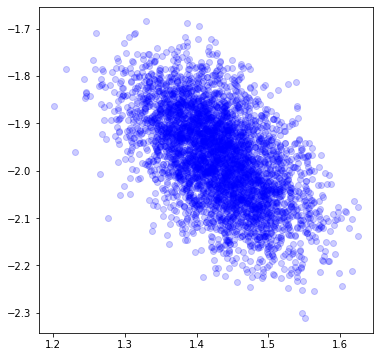

In [28]:
x_test_encoded = encoder.predict(covset_test)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[ 0], x_test_encoded[1], marker='o', c='blue', alpha=0.2)
# plt.colorbar()
plt.show()

## Generate synthetic covariance matrix

In [29]:
np.shape(syscov_sc), np.shape(covset_test), np.shape(covset_test[0])

((31, 31), (2000, 31, 33), (31, 33))

In [30]:
ztest1 = encoder.predict(covset_test[0].reshape((1,31,33)))
ztest2 = encoder.predict(ext_matrix_sc.reshape((1,31,33)))
ztest2

[array([[1.2840481, 1.263945 ]], dtype=float32),
 array([[-1.7092326, -1.6768337]], dtype=float32),
 array([[1.5195158, 1.1767998]], dtype=float32)]

(1, 31, 33, 1)


<AxesSubplot:>

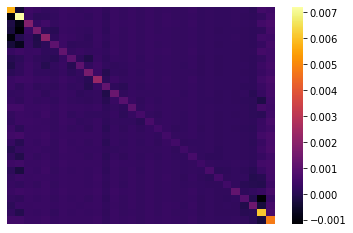

In [31]:
pred_matrix = decoder.predict(ztest2[0])
print(np.shape(pred_matrix))
pred_cov_sc = pred_matrix[0, :, :nsize, 0]
pred_cov = scalercov.inverse_transform(pred_cov_sc)

sns.heatmap(pd.DataFrame(pred_cov), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

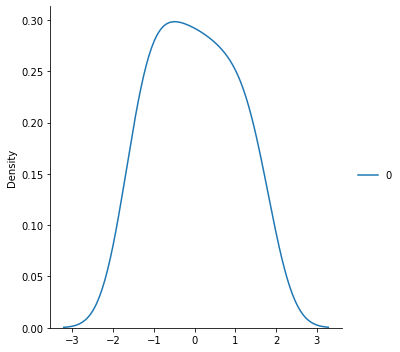

In [32]:
sns.displot(dist_sc, kind='kde')

In [33]:
zmean = np.mean(dist_sc)
zstd = np.std(dist_sc)
# zmean = 0.0
# zstd = 0.5
zmean, zstd

(4.226010222766725e-16, 1.0000000000000002)

In [34]:
z_sample = np.array([[zmean, zstd]])
pred_matrix = decoder.predict(z_sample)

<AxesSubplot:>

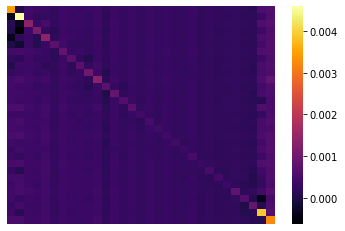

In [35]:
pred_cov_sc = pred_matrix[0, :, :nsize, 0]
pred_cov = scalercov.inverse_transform(pred_cov_sc)

sns.heatmap(pred_cov, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)